# Praca domowa nr 1
Adrianna Grudzień\
6.03.2021 r.

W ramach pracy domowej z przedmiotu Wstęp do uczenia maszynowego przeprowadziłam eksplorację zbioru danych (EDA) na danych ze strony https://www.apispreadsheets.com/datasets/129 dotyczących pożarów lasów.

In [195]:
import pandas as pd
import numpy as np

from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats

# Forest fires - EDA

In [196]:
# wczytywanie danych
fires = pd.read_csv('forest_fires_dataset.csv', delimiter=',')

fires.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51.0,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33.0,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33.0,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97.0,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99.0,1.8,0.0,0.0


In [214]:
# zmieniamy nazwy miesięcy i dni tygodnia na liczby
import time, calendar

fires['month'] = fires['month'].apply(lambda x: time.strptime(x, "%b").tm_mon)
fires['day'] = fires['day'].apply(lambda x: time.strptime(x, "%a").tm_wday + 1)

fires.head()

TypeError: strptime() argument 0 must be str, not <class 'int'>

In [198]:
fires.info()
# nie ma braków; dwa typy danych (numeryczne)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    int64  
 3   day     517 non-null    int64  
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    float64
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(9), int64(4)
memory usage: 52.6 KB


In [199]:
### OZNACZENIA PARAMETRÓW:
# X -> x-axis spatial coordinate within the Montesinho park map: 1 to 9
# Y -> y-axis spatial coordinate within the Montesinho park map: 2 to 9
# month -> month of the year: 'jan' to 'dec'
# day -> day of the week: 'mon' to 'sun'
# FFMC -> FFMC index from the FWI system: 18.7 to 96.20 (wilgotność ściółki - 10 godzin)
# DMC -> DMC index from the FWI system: 1.1 to 291.3 (wilgotność ściółki - 15 dni)
# DC -> DC index from the FWI system: 7.9 to 860.6 (wilgotność ściółki - 53 dni; im większy, tym większa susza)
# ISI -> ISI index from the FWI system: 0.0 to 56.10
# temp -> temperature in Celsius degrees: 2.2 to 33.30
# RH -> relative humidity in %: 15.0 to 100 (relatywna wilgotność)
# wind -> wind speed in km/h: 0.40 to 9.40
# rain -> outside rain in mm/m2 : 0.0 to 6.4
# area -> the burned area of the forest (in ha): 0.00 to 1090.84. The predictor is very skewed towards 0. Might be a good idea to model it with ln(x)

In [200]:
fires.describe()
# w kolumnie 'rain' dla min i kwantyli wartość 0

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,7.475822,4.259188,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,2.275990,2.072929,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,1.000000,1.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,7.000000,2.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,8.000000,5.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,9.000000,6.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,12.000000,7.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


### Zobaczmy rozkłady poszczególnych zmiennych
Pomimo, że zmienne są typu *float*, to nadal możemy mieć zmienne dyskretne/kategoryczne.

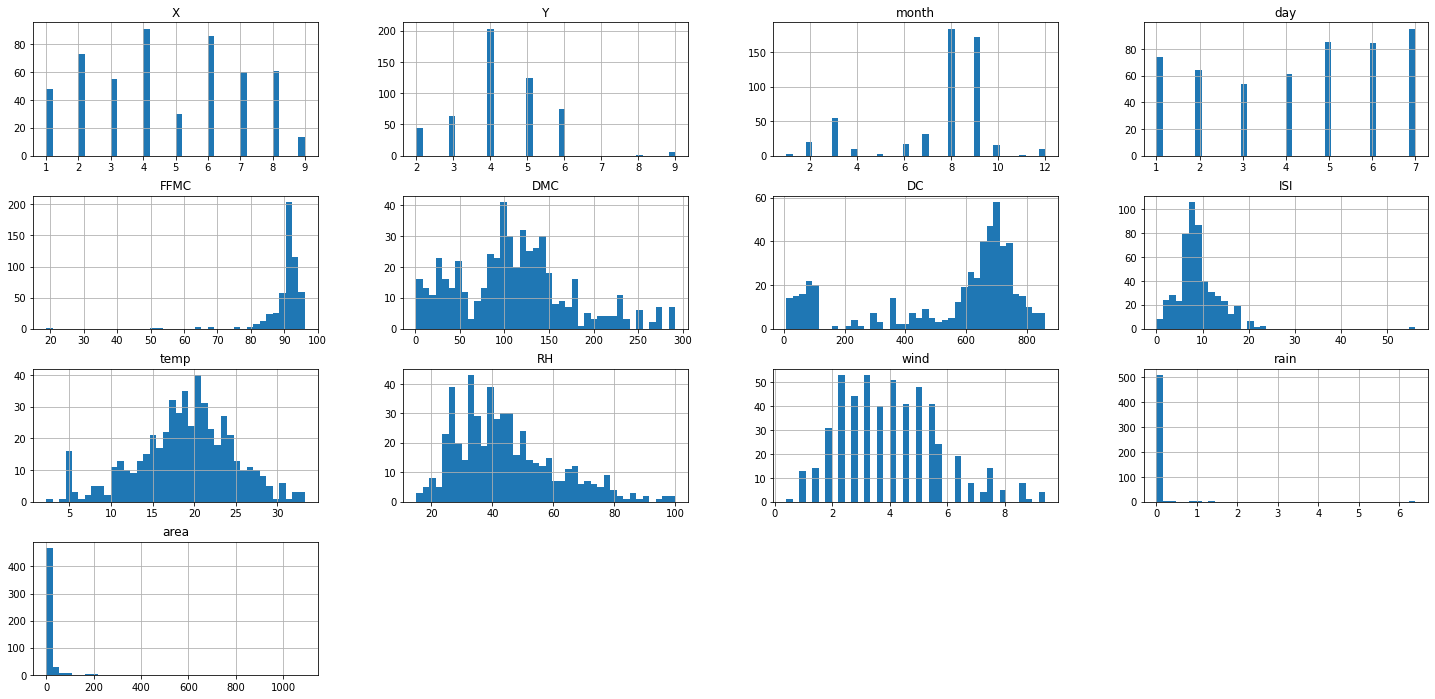

In [217]:
fires.hist(figsize=(25, 12), bins=40)
# fires.hist(figsize=(18, 12), bins=30)
plt.show()

# 'temp', 'RH', 'DMC' ~ rozkład normalny

In [202]:
fires['Y'].value_counts()
# ani razu nie występuje wartość '7'

4    203
5    125
6     74
3     64
2     44
9      6
8      1
Name: Y, dtype: int64

In [203]:
fires['rain'].value_counts()
# przeważnie nie pada

0.0    509
0.8      2
0.2      2
0.4      1
6.4      1
1.4      1
1.0      1
Name: rain, dtype: int64

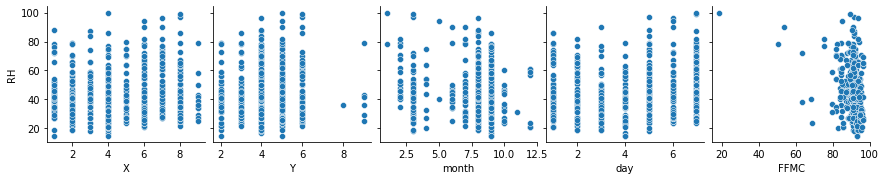

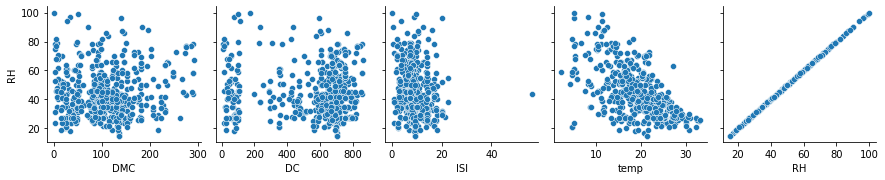

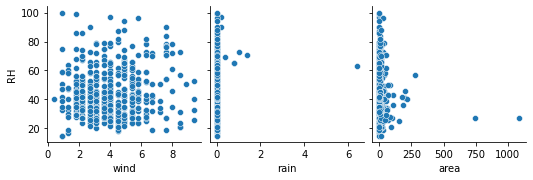

In [204]:
sns.pairplot(fires, y_vars="RH", x_vars=fires.columns.values[:5], diag_kind=None)
sns.pairplot(fires, y_vars="RH", x_vars=fires.columns.values[5:10], diag_kind=None)
sns.pairplot(fires, y_vars="RH", x_vars=fires.columns.values[10:], diag_kind=None)

plt.show()
# ciekawe zależności:
# - im wyższa temperatura, tym niższy współczynnik RH (wilgotność);
# - jeśli RH (wilgotność) jest niska, to płoną duże obszary
# - najsilniejszy wiatr występuje przy niskim RH (wilgotności), największe RH występuje przy najsłabszym wietrze

# Przegląd innych wizualizacji

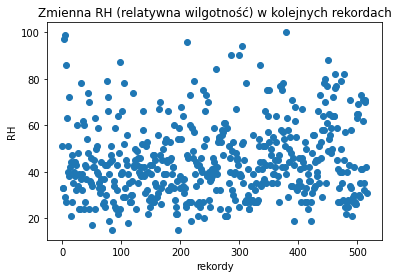

In [205]:
plt.plot(fires['RH'], 'o')
plt.title('Zmienna RH (relatywna wilgotność) w kolejnych rekordach')
plt.xlabel('rekordy')
plt.ylabel('RH')
plt.show()
# częściej wilgotność jest niska (RH jest w granicy 15-60)

/home/ada/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


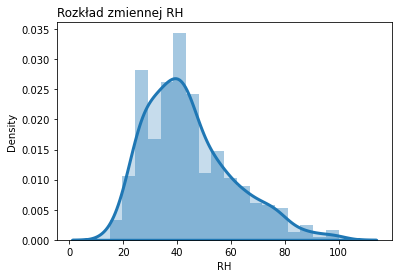

In [218]:
plot_dens=sns.distplot(fires['RH'], hist = True, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3})
plot_dens.set_title('Rozkład zmiennej RH', loc='left')
plt.show()
# rzeczywiście wygląda to na rozkład zbliżony do normalnego

mediana = 42.0
średnia = 44.28820116054158
Q1 = 33.0 Q3 = 53.0


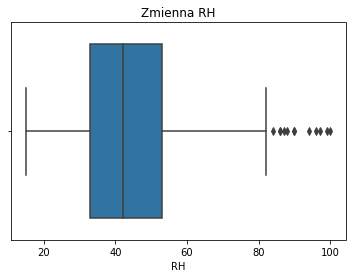

In [207]:
box_plot = sns.boxplot(x=fires['RH'])
box_plot.set_title('Zmienna RH')

print('mediana = %s' % np.median(fires['RH']))
print('średnia = %s' % np.mean(fires['RH']))
print('Q1 = %s' %np.percentile(fires['RH'], 25),'Q3 = %s' %np.percentile(fires['RH'], 75))

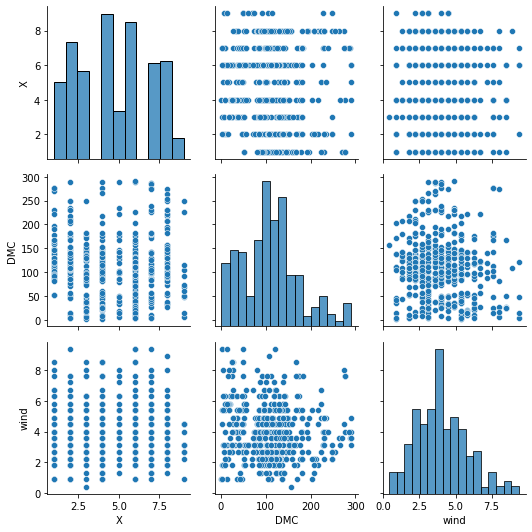

In [208]:
sns.pairplot(fires.iloc[:,[0,5,10]])
plt.tight_layout()

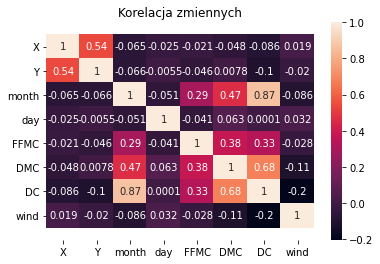

In [209]:
corr=fires.iloc[:,np.r_[0:7,10]].corr()
ax=sns.heatmap(corr, 
            xticklabels=corr.columns,
            yticklabels=corr.columns, annot=True)

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_title('Korelacja zmiennych')
plt.show()

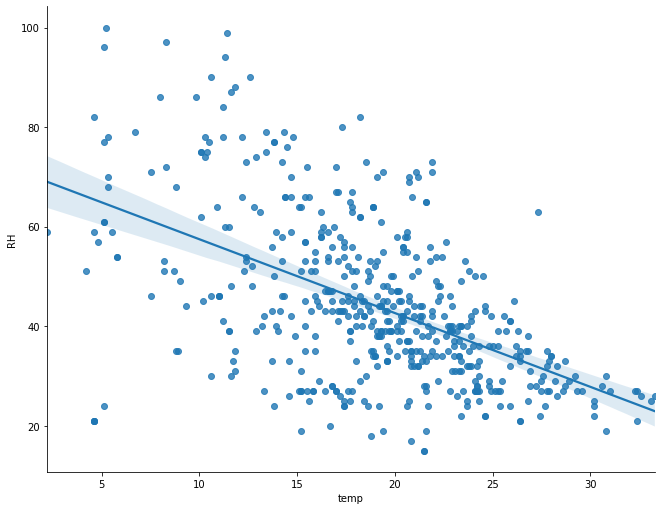

In [210]:
sns.lmplot(x='temp', y='RH', data=fires, height=7, aspect=1.3)
plt.show()
# im wyższa temperatura, tym niższe RH (wilgotność)

<AxesSubplot:xlabel='month', ylabel='area'>

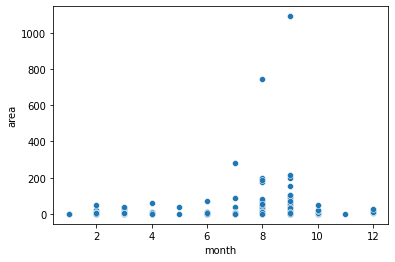

In [211]:
sns.scatterplot(data=fires, x='month', y='area')

# jednorazowo największe obszary lasów płoną w miesiącach letnich (7,8,9), wtedy też jest najwięcej pożarów

<AxesSubplot:xlabel='month', ylabel='area'>

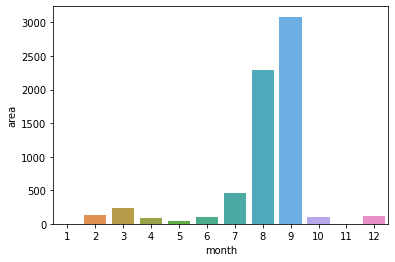

In [212]:
by_months = fires.groupby('month').sum().reset_index()[['month','area']]
sns.barplot(data=by_months, x='month', y='area')
# w sumie największe obszary lasów płoną w sierpniu i wrześniu

# Narzędzie pandas-profilling

In [213]:
from pandas_profiling import ProfileReport
prof = ProfileReport(fires)
prof.to_file(output_file='forest_fires_statistics.html')
# wyniki analizy danych znajdują się w pliku 'forest_fires_statistics.html'

***Ograniczenia*** tego narzędzia:
* używa ogromnych zbiorów danych (im większe dane wejściowe, tym wygenerowanie raportu zajmuje więcej czasu)
* nie wszystkie funkcjonalności są dla nas zawsze przydatne